In [10]:
%pip install ipynb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Constants
MOTIF_MATRIX_IMAGE = '../res/motif_matrix.png'
TEMPORAL_MOTIF_EXTRACTOR_PATH = "/home/aakyildiz/snap/examples/temporalmotifs/temporalmotifsmain"

Note: you may need to restart the kernel to use updated packages.


In [11]:
def split_graph_by_period(input_graph_path, output_path, time_period):
    '''
    Splits a temporal graph into multiple temporal graphs each taking up `time_period` seconds
    
    input_graph_path: the location of the edgelist that is space delimeted and contains (u,v,timestamp) tuples
    output_path: the path in which the garphs will be printed out
    
    Will produce the following files/folders
        {output_path}/periodical_graphs/period_{time_period}/0to{time_period}/0to{time_period}.edgelist
        {output_path}/periodical_graphs/period_{time_period}/0to{time_period}/{time_period}to{2*time_period}.edgelist
        ...
    
    Returns:
        The path of the location of the partitioned graphs (path/to/period_{time_period})
    
    '''
    # make output directory if it's not already made
    output_path+='/periodical_graphs'
    res = os.popen("mkdir -p "+output_path)
    graph = pd.read_csv(input_graph_path, header=None, index_col = False, sep=' ')
    graph.columns = ['u', 'v', 'time']
    graph.sort_values('time', inplace=True)
    start_time = graph.iloc[0]['time']
    end_time = graph.iloc[graph.shape[0]-1]['time']
    output_period_folder = output_path+"/period_"+str(time_period)
    for i in range(start_time, end_time, time_period):
        part_name = str(i)+"to"+str(i+time_period)
        output_part_folder = output_period_folder+"/"+part_name+"/"
        res = os.popen("mkdir -p "+output_part_folder)
        this_g = graph[graph['time'] >= i]
        this_g = this_g[this_g['time']<i+time_period]
        this_g.to_csv(output_part_folder+part_name+'.edgelist', sep=' ', header=False, index=False)
    return output_period_folder

# Extract temporal motifs from a graph 

In [12]:
def extract_temporal_motifs(input_graph_path, output_location, numThreads=32, delta=60):
    '''
    Given a single input graph and an output motifs matrix locaion, will print the 
    motifs matrix and return the motifs as an matrix
    '''
    #parameters
    numThreads = str(numThreads)
    delta = str(delta)
    
    #out_path = input_graph_path.split(".")[0] + "-delta=" + delta + ".temporalmotifs"
    command = TEMPORAL_MOTIF_EXTRACTOR_PATH + " -i:" + input_graph_path \
                                            + " -nt:"  + numThreads\
                                            + " -delta:"  + delta\
                                            + " -o:" + output_location
    res = os.popen(command)
    res.read()
    motifs = []
    with open(output_location, "r") as f:
        for line in f:
            counts = line.replace("\n", "").split(" ")
            motifs.append([int(count) for count in counts])
    return motifs

# Motif heatmap viewer

In [13]:
def display_motifs_heatmap(motifs, image_path=None, figname=None, title=None):
    # open the image 
    # Import image and get x and y extents
    def remove_ticks(ax):
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])

    cmap = plt.cm.get_cmap('Blues', len(np.unique(motifs)))
    if image_path is not None:
        img = plt.imread(image_path)
        x_ext = img.shape[1]/100.0
        y_ext = img.shape[0]/100.0
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax2.imshow(img, alpha=1, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.imshow(motifs, cmap=cmap, alpha = 0.3, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.set_aspect('equal')
        remove_ticks(ax2)
    else:
        fig, ax1 = plt.subplots()
    yticklabels = [str(i) for i in reversed(range(len(motifs)))]
    sns.heatmap(motifs, cmap=cmap, annot=True, fmt="d", ax=ax1, yticklabels=yticklabels)    
    ax1.set_aspect('equal')
    fig.set_size_inches(12,5)
    remove_ticks(ax1)
    if title is not None:
        fig.suptitle(title, fontsize=20)
    plt.show()
    if figname != None:
        fig.savefig(figname, dpi=300, bbox_inches='tight')


# Evolutionary temporal viewer

In [14]:
def evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta, partitioned_graphs_location):
    '''
    Takes a graph and produces time-evolutionary temporal motifs based on the input and produces the 
    output temporal motifs
    '''
    def sort_folders_by_number(folders):
        start_and_folder = [(int(a.split('to')[0]), a) for a in folders]
        return [folder for _, folder in sorted(start_and_folder)]
    location = split_graph_by_period(input_graph_path, partitioned_graphs_location, time_period)
    for part_folder in sort_folders_by_number(list(os.listdir(location))):
        files_prefix = location+'/'+part_folder+'/'+part_folder
        input_graph = files_prefix+'.edgelist'
        temporal_motifs_name=files_prefix+'-delta='+str(delta)
        temporal_motifs_matrix = temporal_motifs_name+'.temporalmotifs'
        emporal_motifs_figure=temporal_motifs_name+'.png'
        display_motifs_heatmap(extract_temporal_motifs(input_graph, output_location=temporal_motifs_matrix,delta=delta),
                               MOTIF_MATRIX_IMAGE, figname=emporal_motifs_figure, title=part_folder)

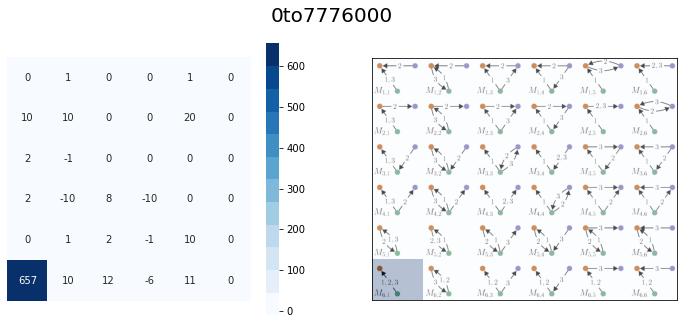

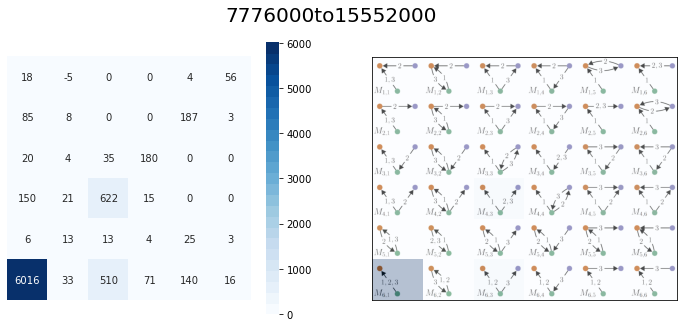

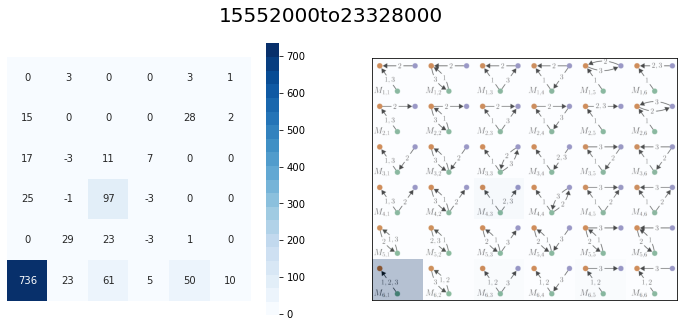

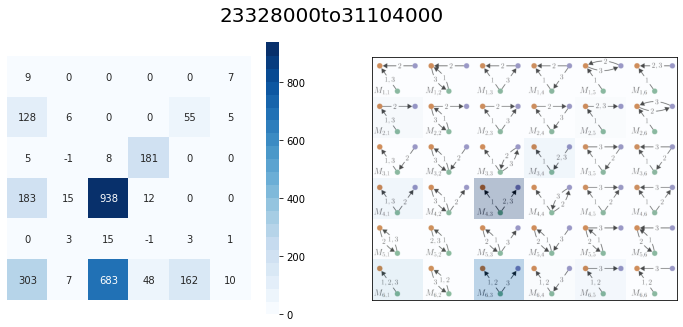

In [15]:
input_graph_path = "/DATA/7A/assets/erc721tokens/Rarible/Rarible.edgelist"
time_period = 60*60*24*90 # 90 day periods 
output_folder = "/DATA/7A/assets/erc721tokens/Rarible/"
#evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=60)
evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=60,
                                     partitioned_graphs_location=output_folder)